In [1]:
import sklearn
print(sklearn.__version__)
# Debe ser version 1.2.2 de lo contrario ejecutar:
#!pip install scikit-learn==1.2.2

1.2.2


In [2]:
def metrics(y_test, predicciones):

    # Coeficiente de determinación (R-cuadrado)
    r2 = r2_score(y_test, predicciones)
    # Error cuadrado medio
    rmse = mean_squared_error(y_true  = y_test, y_pred  = predicciones, squared = False)
    # Error Absoluto Medio
    mae = mean_absolute_error(y_test, predicciones)
    # Error Porcentual Absoluto Medio
    # mape = np.mean(np.abs((y_test - predicciones) / y_test)) * 100
    epsilon=1e-10
    mape = np.mean(np.abs((y_test - predicciones) / (y_test + epsilon))) * 100

    print("R^2:", r2)
    print("RMSE", rmse)
    print("MAE:", mae)
    print("MAPE:", mape, "%")

    r2 = round(r2, 6)
    rmse = round(rmse, 6)
    mae = round(mae, 6)
    mape = round(mape, 6)
    return r2, rmse, mae, mape

# Librerias

In [3]:
import openpyxl
import numpy as np
import time
import os
import pandas as pd
import joblib
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from math import sqrt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from joblib import dump
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

import pickle
import pytz

In [4]:
# Obtener la hora actual en UTC
utc_now = datetime.now(pytz.utc)
mexico_city_tz = pytz.timezone('America/Mexico_City')
mexico_city_now = utc_now.astimezone(mexico_city_tz)
hora_formateada = mexico_city_now.strftime('%Y_%m_%d')
print("Hora actual en Ciudad de México:", hora_formateada)


Hora actual en Ciudad de México: 2024_07_18


# Funciones para el entrenamiento del modelo

In [5]:
def leer_archivo(station, target):

  #file = files[3]
  file_path = os.path.join(dir,station)
  df  = pd.read_csv(file_path)
  dates = df.date
  y = df[target]
  X = df.drop(columns=['date', 'year', 'month', 'day', 'hour', 'minute'])
  X = X.drop(columns=[target])

  return X, y, df, file_path, dates


# Convertir los datos en secuencias adecuadas para RNN
def create_sequences(X, y, time_steps, time_future):
    Xs, ys = [], []
    for i in range(len(X) - time_steps-time_future):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps+ time_future])
    return np.array(Xs), np.array(ys)


def create_sequences2(X, y, time_steps, time_future):
  Xs, ys = [], []
  for i in range(len(X) - time_steps-time_future):
    df = X[i:(i + time_steps)]
    array = df.to_numpy()
    # Aplanar el array a un vector
    vector = array.flatten()
    Xs.append(vector)
    ys.append(y[i + time_steps+time_future])
  return np.array(Xs), np.array(ys)


def XGBoost_grid(X,y, station_name, fecha, best_xgb_model_dir, best_xgb_params_dir, time_steps, time_future, results_dir):

  X_seq, y_seq = create_sequences2(X, y, time_steps, time_future)
  # Dividir los datos en conjunto de entrenamiento y prueba
  X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

  # Definir el modelo XGBoost
  xgb_model = XGBRegressor()

  # Definir los parámetros para GridSearchCV
  param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [3, 4, 5],
      'learning_rate': [0.01, 0.05, 0.1]
  }

  # Inicializar GridSearchCV
  grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='r2',return_train_score=True)

  # Entrenar GridSearchCV
  grid_search.fit(X_train, y_train)

  results = grid_search.cv_results_
  # Guardar los resultados en un archivo
  with open(results_dir, 'wb') as f:
      pickle.dump(results, f)

  # Obtener los mejores parámetros
  best_params = grid_search.best_params_
  print("Mejores parámetros encontrados:", best_params)

  # Entrenar el modelo final con los mejores parámetros
  best_xgb_model = XGBRegressor(**best_params)
  best_xgb_model.fit(X_train, y_train)

  # Evaluar el modelo en el conjunto de prueba
  rmse = np.sqrt(mean_squared_error(y_test, best_xgb_model.predict(X_test)))
  print("RMSE en conjunto de prueba:", rmse)
  # Guardar el modelo
  joblib.dump(best_xgb_model, best_xgb_model_dir)
  joblib.dump(best_params, best_xgb_params_dir)

  loaded_model = joblib.load(best_xgb_model_dir)
  predicciones = loaded_model.predict(X_test)
  r2 = r2_score(y_test, predicciones)
  print("Coeficiente de determinación (R2):", r2)
  [r2, RMSE, MAE, MAPE] = metrics(y_test, predicciones)
  return [r2, RMSE, MAE, MAPE]


## Entrenamos con los datos del tráfico (considerando solo la calle más cercana)

In [6]:
dir = '/content'
files = os.listdir(dir)
print(files)
metric_results_list= []
column_names = ['MODEL', 'TRAFFIC_DATA','TARGET', 'STATION','R2', 'RMSE', 'MAE', 'MAPE', 'LEN_X', 'DATE','TIME_STEPS', 'TIME_FUTURE','HORA']
for station in files:
  if station == 'air_traffic_MER.csv':
    target = "O3"
    X, y, df, file_path, dates = leer_archivo(station, target)
    time_steps = 12
    time_future =1
    X_seq, y_seq = create_sequences2(X, y, time_steps, time_future)
    # Dividir los datos en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
    print(station, "X_train",len(X_train), "Y_test",len(y_test))

['.config', 'air_traffic_MER.csv', 'sample_data']
air_traffic_MER.csv X_train 749 Y_test 188


In [7]:
X

,CO,NO,NOX,NO2,PM10,PM25,RH,SO2,TMP,WDR,WSP,traffic
0,0.572222,0.365385,0.3700,0.284553,0.195489,0.218750,0.585366,0.046875,0.142857,0.477778,0.186441,0.62950
1,0.375000,0.198718,0.2525,0.325203,0.360902,0.281250,0.524390,0.031250,0.238095,0.377778,0.169492,0.71150
2,0.363889,0.118590,0.2325,0.455285,0.300752,0.250000,0.439024,0.031250,0.333333,0.258333,0.186441,0.37950
3,0.225000,0.041667,0.1300,0.317073,0.353383,0.343750,0.390244,0.015625,0.428571,0.255556,0.254237,0.54300
4,0.141667,0.012821,0.0600,0.170732,0.338346,0.364583,0.317073,0.015625,0.523810,0.363889,0.423729,0.41150
...,...,...,...,...,...,...,...,...,...,...,...,...
945,0.066667,0.003205,0.0250,0.073171,0.180451,0.239583,0.146341,0.015625,0.857143,0.086111,0.372881,0.91025
946,0.086111,0.006410,0.0275,0.081301,0.075188,0.135417,0.146341,0.015625,0.904762,0.933333,0.474576,0.67725
947,0.127778,0.003205,0.0650,0.219512,0.225564,0.197917,0.268293,0.015625,0.761905,0.172222,0.355932,0.84360
948,0.180556,0.003205,0.1050,0.341463,0.195489,0.177083,0.304878,0.031250,0.714286,0.272222,0.389831,0.92625


In [8]:
dir = '/content'
#dir_metrics_result = 'metric_results.csv'
files = os.listdir(dir)
print(files)
metric_results_list= []
column_names = ['MODEL', 'TRAFFIC_DATA','TARGET', 'STATION','R2', 'RMSE', 'MAE', 'MAPE', 'LEN_X', 'DATE','TIME_STEPS', 'TIME_FUTURE','HORA']
for station in files:
  if station == 'air_traffic_MER.csv':
    target = "O3" # Contaminante a predecir
    X, y, df, file_path, dates = leer_archivo(station, target)
    print(file_path)
    station_name = station[12:-4]
    fecha = hora_formateada
    time_steps = 12 #Datos que toma históricos para hacer la predicción
    time_future =1 #Predicción al futuro en horas

    results_dir = 'results_XGB_'+'timesteps_'+str(time_steps)+'_'+target+'_'+str(time_future)+'_'+'_'+station_name +'_'+fecha+'.pkl'
    best_xgb_model_dir = 'best_model_XGBoost_'+str(time_steps)+'timesteps_'+target+'_'+station_name +'_'+fecha+'.pkl'
    best_xgb_params_dir = 'best_paramas_XGBoost_'+str(time_steps)+'timesteps_'+target+'_'+station_name +'_'+fecha+'.pkl'
    [r2, RMSE, MAE, MAPE] = XGBoost_grid(X,y, station, fecha, best_xgb_model_dir, best_xgb_params_dir, time_steps, time_future, results_dir)
    utc_now = datetime.now(pytz.utc)
    mexico_city_tz = pytz.timezone('America/Mexico_City')
    mexico_city_now = utc_now.astimezone(mexico_city_tz)
    hora_formateada = mexico_city_now.strftime('%Y-%m-%d %H:%M')
    metric_results_list = []
    metric_results_list.append(['XGBoost', 'NEAREST_STREET', target,station_name, r2, RMSE, MAE, MAPE, len(X), fecha, time_steps, time_future, hora_formateada])
    metric_results_df = pd.DataFrame(metric_results_list, columns=column_names)
    metric_results_df
    #last_metrics_result = pd.read_csv(dir_metrics_result)
    #all_metrics = pd.concat([last_metrics_result, metric_results_df])
    #all_metrics.to_csv(dir_metrics_result, index=False)

['.config', 'air_traffic_MER.csv', 'sample_data']
/content/air_traffic_MER.csv
Mejores parámetros encontrados: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
RMSE en conjunto de prueba: 0.1151822373377758
Coeficiente de determinación (R2): 0.669322655238509
R^2: 0.669322655238509
RMSE 0.1151822373377758
MAE: 0.07857886048208891
MAPE: 343146592.35468733 %


## Prueba de las predicciones, cargando el modelo desde el archivo

In [10]:
import pickle

model_dir = '/content/best_model_XGBoost_12timesteps_O3_MER_2024_07_18.pkl'

loaded_model = joblib.load(model_dir)
predicciones = loaded_model.predict(X_test)
r2 = r2_score(y_test, predicciones)
print("Coeficiente de determinación (R2):", r2)

print(predicciones)

Coeficiente de determinación (R2): 0.669322655238509
[ 0.28666085  0.02010945  0.5536674   0.00666349  0.34419554  0.4223059
  0.43941122  0.03405611  0.47035953  0.06087296  0.48460063  0.01599118
  0.05164488  0.06558258  0.49127692  0.15276906  0.01808466  0.49513826
  0.13440648  0.02961547  0.05264339  0.54244584  0.46132806  0.1278311
  0.12037313  0.5168912   0.4698457   0.14701872  0.6224876   0.08140942
  0.584766    0.06586271  0.24665542  0.03364535  0.38215476  0.14405948
  0.04368433  0.09312633  0.313612    0.5570201   0.06808124  0.02514658
  0.11825221  0.20033726  0.07499862  0.1013247   0.14770734  0.4262408
  0.40206447  0.39936617  0.48982778  0.07980509  0.36370704  0.43994755
  0.04359748  0.08274779  0.24874493  0.1052792   0.22097786  0.16800043
  0.3262409   0.5349626   0.00757069  0.02848443  0.49711248  0.18528415
  0.47449133  0.31765288  0.31457075  0.21598221  0.13986243  0.45227924
  0.12140376  0.31194076  0.5472469   0.01457815  0.01478887 -0.0075574
  

In [11]:
def graficar_predicciones(new_hours, target, predicciones, variable):
  """

  Args:
    new_hours:
    target:
    predicciones:
  """
  fechas = new_hours
  # Convertir las fechas a objetos datetime
  fechas_datetime = [datetime.strptime(fecha, '%Y-%m-%d %H:%M:%S') for fecha in fechas]

  # Crear el gráfico
  plt.figure(figsize=(10, 6))

  # Graficar el target y las predicciones en el eje Y
  plt.plot(fechas_datetime, target, label='Target', marker='o')
  plt.plot(fechas_datetime, predicciones, label='Predicciones', marker='o')

  # Configurar formato de fecha en el eje X
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

  # Rotar las fechas para mayor legibilidad
  plt.gcf().autofmt_xdate()

  # Configurar etiquetas y título
  plt.xlabel('Fechas')
  plt.ylabel('Valor')
  title1 = 'Target vs Predicciones a lo largo del tiempo' + variable
  plt.title(title1)

  # Mostrar la leyenda
  plt.legend()
  plt.grid(True)
  # Mostrar el gráfico
  plt.show()

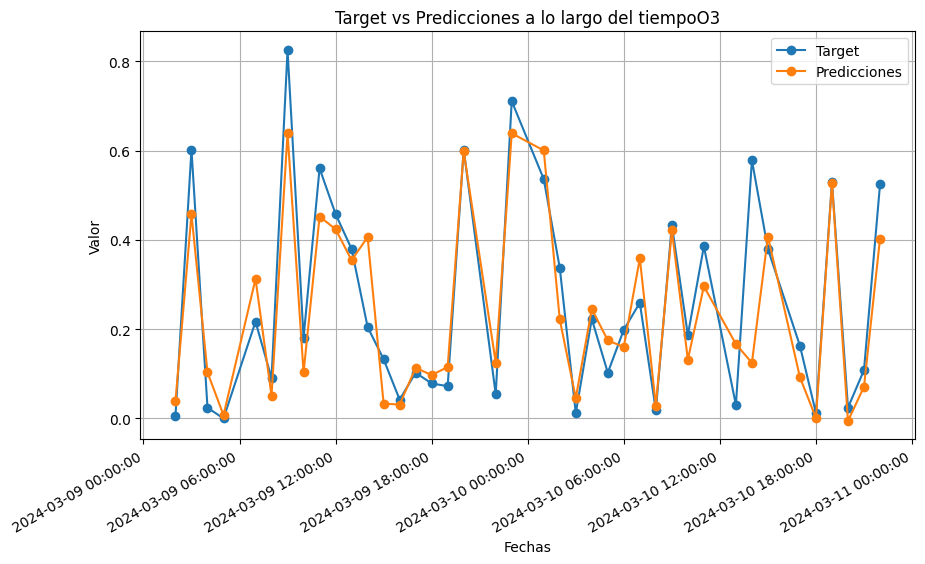

In [12]:
graficar_predicciones(dates[100:140],y_test[100:140], predicciones[100:140], 'O3')